In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
from functools import partial

import data
import config
import features
import train_reg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
df = pd.read_pickle(oj(config.DIR_PROCESSED, 'df_full.pkl'))

There are a few very important metadata keys
- *dset*: which imaging condition each track used
- *cell_num*: which cell a track came from
- *split*: whether a track is in the train or test set 
- *short*: track has lifetime <= 15 and we usually exclude them bc they are usually negative
- *hotspots*: track is too long / possibly an err and we usually exclude them

The actual data has a couple keys
- *X*: the clathrin track
- *Y*: the auxilin track

The outcomes we care about
- *y_consec_thresh* (binary classification)
- *Y_sig_mean_normalized* (regression)

In [17]:
# config.DSETS has a bunch of metadata on each dataset
print('names of different datasets:', df['dset'].unique())

names of different datasets: ['clath_aux+gak_a7d2' 'clath_aux+gak' 'clath_aux+gak_a7d2_new'
 'clath_aux+gak_new' 'clath_gak' 'clath_aux_dynamin']


In [18]:
# each dataset has different number of cells each with different number of tracks
df.groupby('dset')['cell_num'].value_counts()

dset           cell_num                 
clath_aux+gak  EGFP-GAK F6/6                1546
               EGFP-GAK F6/4                1205
               EGFP-GAK F6/5                1010
               EGFP-GAK F6/7                 947
               EGFP-GAK F6/3                 871
                                            ... 
clath_gak      CLTA-TagRFP EGFP-GAK A8/1    2152
               CLTA-TagRFP EGFP-GAK A8/6    2026
               CLTA-TagRFP EGFP-GAK A8/2    1710
               CLTA-TagRFP EGFP-GAK A8/4    1482
               CLTA-TagRFP EGFP-GAK A8/5    1326
Name: cell_num, Length: 75, dtype: int64

In [27]:
# each dataset has different number of tracks in train/test
df.groupby('dset')['split'].value_counts()

dset                    split
clath_aux+gak           train      6056
                        test       1593
clath_aux+gak_a7d2      train      7594
                        test       2497
clath_aux+gak_a7d2_new  train     50623
                        test      17106
clath_aux+gak_new       train     16745
                        test       4088
clath_aux_dynamin       train    164614
                        test      45973
clath_gak               train     13277
                        test       5368
Name: split, dtype: int64

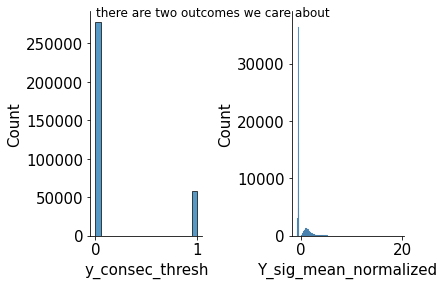

In [26]:
plt.suptitle('there are two outcomes we care about')
plt.subplot(1, 2, 1)
sns.histplot(df, x='y_consec_thresh')
plt.subplot(1, 2, 2)
sns.histplot(df, x='Y_sig_mean_normalized')
plt.show()

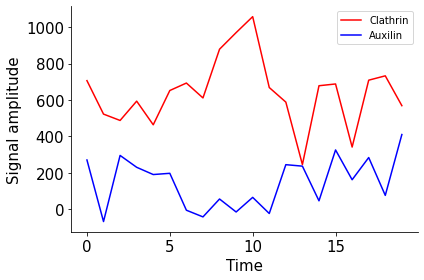

In [22]:
# we can ignore most keys that start with y_ (they are related to theoutcome, not input features)
# the main tracks are in 'X' and 'Y'
ex = df[df.lifetime == 20].iloc[0]
plt.plot(ex['X'], label='Clathrin', color='red')
plt.plot(ex['Y'], label='Auxilin', color='blue')
plt.xlabel('Time')
plt.ylabel('Signal amplitude')
plt.legend()
plt.show()

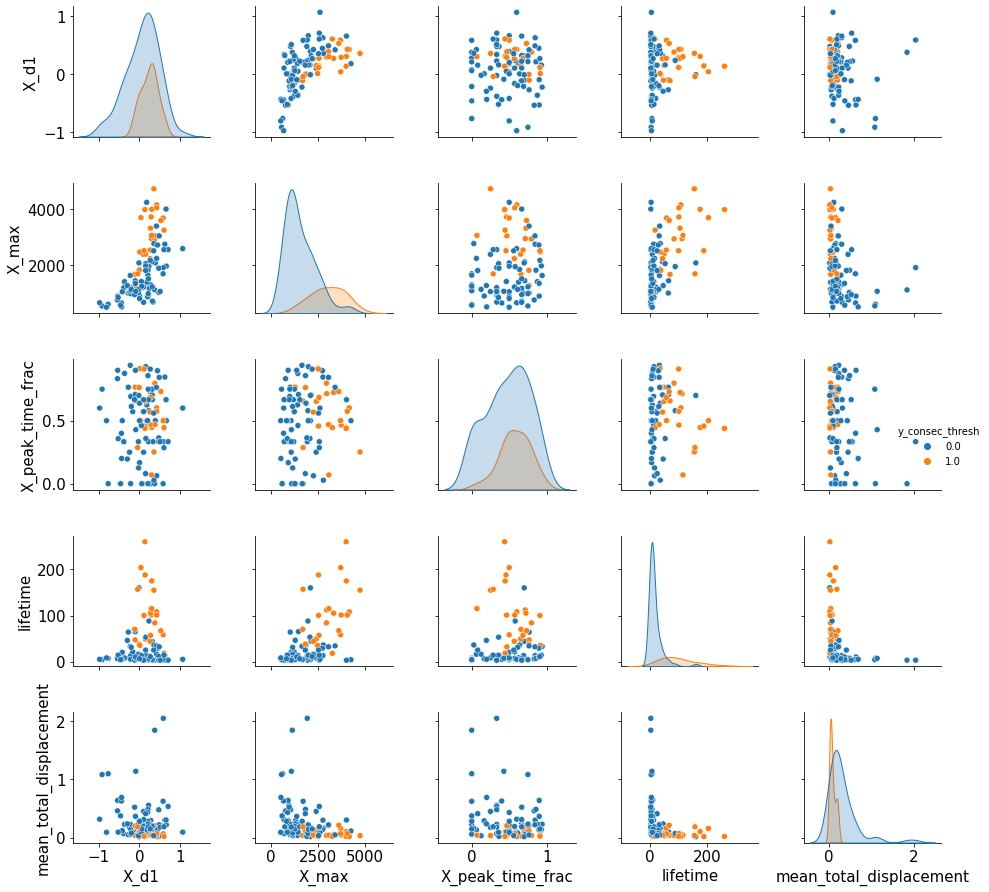

In [19]:
# these are most of the key features
feat_names = [
    'X_d1', 'X_d2', 'X_d3', 'X_max','X_mean',
    'X_min','X_peak_time_frac','X_std', 'fall', 'lifetime', 'rise', 
    'mean_square_displacement', 'mean_total_displacement'
]

# let's look at a subset of them
# they have not been normalized - probably a good idea to normalize them all within each cell
outcome_def = 'y_consec_thresh'
N = 100
sns.pairplot(df.head(N)[feat_names[::3] + [outcome_def]], hue=outcome_def)
plt.show()